# **Importowanie bibliotek**

In [130]:
from PyPDF2 import PdfReader
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random
from gensim import corpora, models
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

#nltk.download('stopwords')

# **Funkcja czytająca pliki w formacie PDF**
Funkcja `read_pdf` służy do odczytywania zawartości plików PDF. Przyjmuje argument `file_path`, który jest ścieżką do pliku PDF.

In [3]:
def read_pdf(file_path):
    with open(file_path, 'rb') as file:
        pdf_reader = PdfReader(file)
        num_pages = len(pdf_reader.pages)

        text = ''
        for page in pdf_reader.pages:
            text += page.extract_text()
        
        return text

In [6]:
book1_path = 'books/J.R.R. Tolkien - Hobbit, czyli tam i z powrotem.pdf'
book2_path = 'books/J.R.R. Tolkien - Władca pierścieni. Bractwo Pierścienia. Tom 1.pdf'
book3_path = 'books/J.R.R. Tolkien - Władca Pierścieni. Dwie Wieże. Tom 2.pdf'
book4_path = 'books/J.R.R. Tolkien - Władca Pierścieni. Powrót Króla. Tom 3.pdf'

book1 = read_pdf(book1_path)
book2 = read_pdf(book2_path)
book3 = read_pdf(book3_path)
book4 = read_pdf(book4_path)

# **Funkcja do czyszczenia i tokenizacji tekstu**

Funkcja `cleaned_book` to zmodyfikowana i zoptymalizowana funkcja do czyszczenia tekstu, którą wykorzystywaliśmy na zajęciach. Pozbawiona została ona linijek kodu odpowiedzialnych za usuwanie nazw użytkowników, wzmianek, oznaczeń, tagowań, retweetów, url-ów, a także kodu HTMLowego. W procesie czyszczenia wykorzystuje ona wbudowaną w bibliotece NLTK funkcję odpowiedzialną za tokenizację tekstu `nltk.word_tokenize` oraz plik `polish_stopwords.txt` zawierający polskie stopwordsy, do którego dodany został zbiór zawierający zgłoski lub przypadkowe zlepy liter, które same w sobie nie mają żadnego znaczenia i które powstały wskutek błędnego zinterpretowania tekstu. To pomoże uzyskać lepsze wyniki w dalszych krokach podczas generowania chmur słów czy analizy tematycznej. Próbka badawcza pod względem liczebności słów w korpusie wciąż będzie wystarczająco duża, by móc przeprowadzić analizę tekstu.

In [48]:
def cleaned_book(text):
    temp = re.sub("\s{2,}", " ", text) #usunięcie podwójnych spacji
    temp = re.sub("(\r\n|\r|\n)", " ", temp) #usunięcie przerw między słowami, entery
    temp = temp.lower() #zamienia wszystkie znaki na małe litery
    temp = re.sub("[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", " ", temp) #usunięcie znaków specjalnych
    #temp = re.sub("\d", "", temp) #usunięcie cyfr
    temp = re.sub("[^\w\s]", "", temp) #usunięcie znaków specjalnych
    temp = temp.strip() #usunięcie spacji lub odstępów na końcach tekstu
    
    #Implementacja stopwordsów dla języka polskiego z pliku polish_stopwords.txt oraz dodanie do zbioru wyrażeń powstałych wskutek błędnego oczyszczenia tekstu
    with open("polish_stopwords.txt", "r", encoding="utf-8") as file:
        polish_stopwords = [line.strip() for line in file.readlines()]
        
    stopwords = polish_stopwords + ['pa', 'ba', 'zd', 'ec', 'pi', 'cza', 'cze', 'pie', 'gło', 'la', 'zw', 'roz', 'ra', 'si', 
                                    'ac', 'sci', 'ał', 'ły', 'sc', 'ju', 'mo', 'wi', 'ście', 'ąc', 'ął', 'smy', 'ło', 'scie', 
                                    'ni', 'ad', 'ła', 'ść', 'zy', 'sli', 'ści', 'śli', 'łem', 'mia', 'śmy', 'ęli', 'ko', 'ace',
                                    'gimli', 'snie', 'ęc', 'ąć', 'acy', 'agn', 'ksi', 'acych', 'edzy', 'ży', 'łe', 'eli', 'edzie', 
                                    'sród', 'świ', 'plu', 'elro', 'dwarf', 'sprz', 'ama', 'adałe']
    
    #Tokenizacja tekstu za pomocą biblioteki NLTK
    cleaned_and_tokenized = nltk.word_tokenize(temp)
    
    #Usunięcie stopwordsów
    cleaned_and_tokenized_without_stopwords = [word for word in cleaned_and_tokenized if word.lower() not in stopwords]
    
    return cleaned_and_tokenized_without_stopwords

# **Oczyszczenie książek**

In [49]:
book1_cleaned = cleaned_book(book1)
book2_cleaned = cleaned_book(book2)
book3_cleaned = cleaned_book(book3)
book4_cleaned = cleaned_book(book4)

# **Policzenie wszystkich słów w korpusie składającym się z 4 książek**

In [50]:
total_words = len(book1_cleaned) + len(book2_cleaned) + len(book3_cleaned) + len(book4_cleaned)

print("Liczba wszystkich słów w korpusie:", total_words)

Liczba wszystkich słów w korpusie: 353311


# **Wygenerowanie chmury słów dla słów występujących we wszystkich 4 książkach**

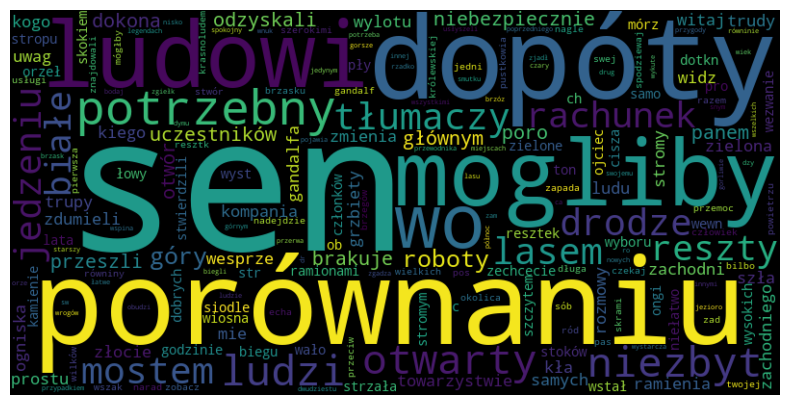

In [51]:
common_words = set(book1_cleaned).intersection(book2_cleaned, book3_cleaned, book4_cleaned)

wordcloud_common = WordCloud(width=800, height=400).generate(' '.join(common_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_common, interpolation='bilinear')
plt.axis('off')
plt.show()

# **Wygenerowanie chmur słów dla unikatowych słów występujących tylko w poszczególnych książkach**

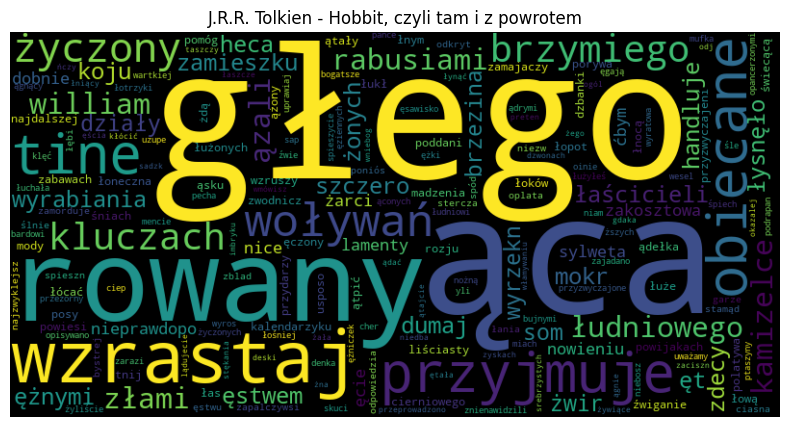

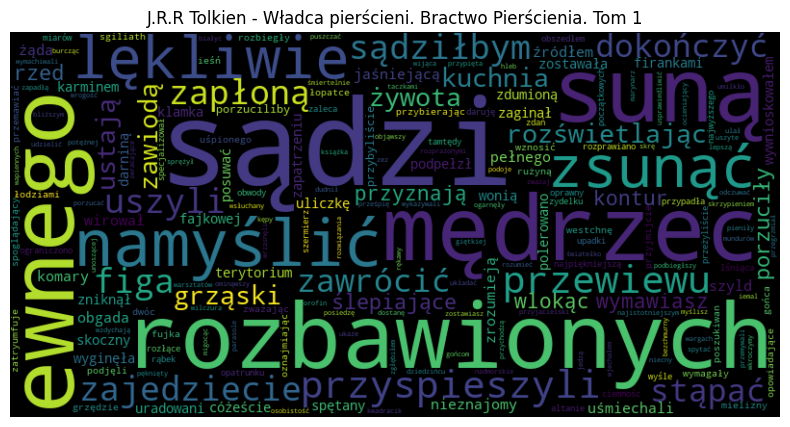

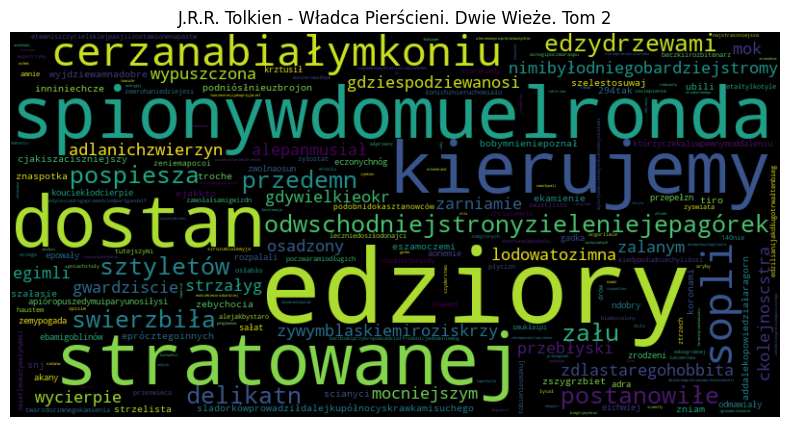

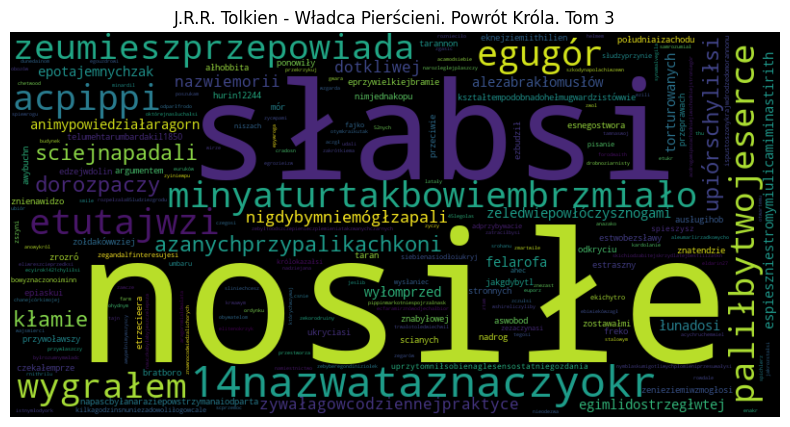

In [52]:
unique_words_book1 = set(book1_cleaned) - set(book2_cleaned) - set(book3_cleaned) - set(book4_cleaned)
unique_words_book2 = set(book2_cleaned) - set(book1_cleaned) - set(book3_cleaned) - set(book4_cleaned)
unique_words_book3 = set(book3_cleaned) - set(book1_cleaned) - set(book2_cleaned) - set(book4_cleaned)
unique_words_book4 = set(book4_cleaned) - set(book1_cleaned) - set(book2_cleaned) - set(book3_cleaned)

wordcloud_book1 = WordCloud(width=800, height=400).generate(' '.join(unique_words_book1))
wordcloud_book2 = WordCloud(width=800, height=400).generate(' '.join(unique_words_book2))
wordcloud_book3 = WordCloud(width=800, height=400).generate(' '.join(unique_words_book3))
wordcloud_book4 = WordCloud(width=800, height=400).generate(' '.join(unique_words_book4))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_book1, interpolation='bilinear')
plt.title('J.R.R. Tolkien - Hobbit, czyli tam i z powrotem')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_book2, interpolation='bilinear')
plt.title('J.R.R Tolkien - Władca pierścieni. Bractwo Pierścienia. Tom 1')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_book3, interpolation='bilinear')
plt.title('J.R.R. Tolkien - Władca Pierścieni. Dwie Wieże. Tom 2')
plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_book4, interpolation='bilinear')
plt.title('J.R.R. Tolkien - Władca Pierścieni. Powrót Króla. Tom 3')
plt.axis('off')
plt.show()

# **Grupowanie książek metodą k-means**

W tym projekcie do grupowania książek autorstwa J.R.R. Tolkiena wykorzystano **algorytm centroidów (k-means clustering)** będącym jednym z najpopularniejszych algorytmów stosowanych w analizie skupień. Ma on na celu podział zbioru danych na K liczbę grup.

Algorytm k-means w Text Mining rozpoczyna proces eksploracji tekstu od wosowego wybrania centroidów, czyli punktów reprezentujących środki grup. Następnie algorytm iteracyjnie oblicza odległość każdego punktu danych od każdego centroidu i przypisuje go do grupy, której centroid jest najbliższy. W tym projekcie bazą jest saga powieści J.R.R. Tolkiena składająca się z Hobbita oraz 3 części Władcy pierścieni, więc w tym przypadku algorytm nie będzie miał trudnego zadania do wykonania. Proces przypisywania punktów danych do grup i aktualizacji centroidów jest powtarzany aż do momentu, gdy punkty przestają zmieniać przypisanie (położenie) lub gdy osiągnięta zostanie maksymalna liczba iteracji.

Grupowania książek dokonano za pomocą algotymu k-means, ale z wykorzystaniem 3 różnych reprezentacji tekstowych - Bag of words, TF-IDF oraz word embedding.

### Przygotowanie danych

In [20]:
books = [book1_cleaned, book2_cleaned, book3_cleaned, book4_cleaned]
book_titles = ['Hobbit', 'Władca Pierścieni: Bractwo Pierścienia', 'Władca Pierścieni: Dwie Wieże', 'Władca Pierścieni: Powrót Króla']

#Połączenie treści książek w pojedyncze ciągi znaków
books_combined = [' '.join(book) for book in books]

In [21]:
#Tworzenie reprezentacji Bag-of-Words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(books_combined)

#Grupowanie k-means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

#Przypisanie książek do grup
book_groups = {}
for i, label in enumerate(kmeans.labels_):
    if label not in book_groups:
        book_groups[label] = []
    book_groups[label].append(book_titles[i])

#Wyświetlenie wyników grupowania posortowanych według etykiet grupy
for label in sorted(book_groups.keys()):
    books = book_groups[label]
    print(f"Grupa {label+1}:")
    for book in books:
        print(f"- {book}")
    print()

Grupa 1:
- Władca Pierścieni: Bractwo Pierścienia

Grupa 2:
- Hobbit
- Władca Pierścieni: Dwie Wieże
- Władca Pierścieni: Powrót Króla



Grupowanie za pomocą TF-IDF:

In [213]:
#Tworzenie reprezentacji TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(books_combined)

#Grupowanie k-means
k = 2  #liczba grup
kmeans = KMeans(n_clusters=k)
kmeans.fit(X)

#Przypisanie książek do grup
book_groups = {}
for i, label in enumerate(kmeans.labels_):
    if label not in book_groups:
        book_groups[label] = []
    book_groups[label].append(book_titles[i])

#Wyświetlenie wyników grupowania posortowanych według etykiet grupy
for label in sorted(book_groups.keys()):
    books = book_groups[label]
    print(f"Grupa {label+1}:")
    for book in books:
        print(f"- {book}")
    print()

Grupa 1:
- Hobbit

Grupa 2:
- Władca Pierścieni: Bractwo Pierścienia
- Władca Pierścieni: Dwie Wieże
- Władca Pierścieni: Powrót Króla



Grupowanie za pomocą word embedding:

In [212]:
#Przygotowanie modelu word embedding
model = Word2Vec([book.split() for book in books_combined], min_count=1)

#Tworzenie reprezentacji wektorowej dla każdej książki
book_embeddings = np.array([np.mean([model.wv[word] for word in book.split() if word in model.wv] or [np.zeros(model.vector_size)], axis=0) for book in books_combined])

#Grupowanie k-means
k = 2
kmeans = KMeans(n_clusters=k)
kmeans.fit(book_embeddings)

#Przypisanie książek do grup
book_groups = {}
for i, label in enumerate(kmeans.labels_):
    if label not in book_groups:
        book_groups[label] = []
    book_groups[label].append(book_titles[i])

#Wyświetlenie wyników grupowania posortowanych według etykiet grupy
for label in sorted(book_groups.keys()):
    books = book_groups[label]
    print(f"Grupa {label+1}:")
    for book in books:
        print(f"- {book}")
    print()


Grupa 1:
- Władca Pierścieni: Bractwo Pierścienia
- Władca Pierścieni: Dwie Wieże
- Władca Pierścieni: Powrót Króla

Grupa 2:
- Hobbit



c:\Users\Łukasz\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Jak można zauważyć, modele `TF-IDF` oraz `Word2vec` w metodzie k-means dobrze poradziły sobie z procesem grupowania. Powieści J.R.R. Tolkiena zostały rozpoznane i odpowiednio sklasyfikowane (Hobbit został oddzielony od Władcy pierścieni). Z tym zadaniem nie poradził sobie jednak model wykorzystujący `Bag of words`. Może to wynikać z faktu, iż, w przeciwieństwie do `TF-IDF` i `Word2Vec`, które są nieco bardziej zaawansowanymi narzędziami, `Bag of words` jest najprostszym modelem reprezentacji tekstów, w którym kontekst nie jest uwzględniany, zatem kolejność słów nie odgrywa znaczącej roli, a nacisk kładziony jest po prostu na występowaniu danego słowa w tekście.

# **Modele wątków (topic modelling)**

Analiza tematyczna za pomocą modelu **LDA (Latent Dirichlet Allocation)** jest techniką wykorzystywaną do identyfikacji ukrytych tematów w tekście. Model LDA zakłada, że każdy dokument składa się z różnych tematów, a każde słowo w dokumencie jest przypisane do jednego z tych tematów. Istnieją jednak odstępstwa od tej reguły, co można zaobserwować na poniższym przykładzie. Wynika to z faktu, iż analizowanym zbiorem dokumentów jest saga powieści autorstwa J.R.R Tolkiena, w której wątki muszą się zazębiać. Stąd hasło "frodo" dotyczące jednego z głównych bohaterów, Frodo Bagginsa, pojawia się w więcej niż jednym dokumencie.

W przypadku poniższej analizy model LDA został zastosowany do czterech książek: "Hobbit, czyli tam i z powrotem", "Władca pierścieni. Bractwo Pierścienia. Tom 1", "Władca Pierścieni. Dwie Wieże. Tom 2" oraz "Władca Pierścieni. Powrót Króla. Tom 3". Do każdej książki został przypisany temat o indeksie 0, aby uzyskać motyw przewodni danej książki, a następnie zostały wypistowane słowa kluczowe wraz z ich wagami.

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

#Przygotowanie korpusu tekstowego
corpus = [book1_cleaned, book2_cleaned, book3_cleaned, book4_cleaned]
book_titles = ["Hobbit, czyli tam i z powrotem", "Władca pierścieni. Bractwo Pierścienia. Tom 1",
               "Władca Pierścieni. Dwie Wieże. Tom 2", "Władca Pierścieni. Powrót Króla. Tom 3"]

#Inicjalizacja TfidfVectorizer
vectorizer = TfidfVectorizer(lowercase=False)
X = vectorizer.fit_transform(corpus)

#Konfiguracja i dopasowanie modelu LDA dla każdej książki
for book_idx, book in enumerate(corpus):
    lda = LatentDirichletAllocation(n_components=1, random_state=42)
    lda.fit(X[book_idx])

    #Wyświetlenie wyników
    print(f"Book #{book_idx+1}: {book_titles[book_idx]}")
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(lda.components_):
        print(f"Temat #{topic_idx}:")
        top_words_indices = topic.argsort()[:-11:-1]
        top_words = [feature_names[i] for i in top_words_indices]
        top_word_scores = [topic[i] for i in top_words_indices]
        for word, score in zip(top_words, top_word_scores):
            print(f"{word}: {score}")
        print()

Book #1: Hobbit, czyli tam i z powrotem
Temat #0:
bilbo: 1.381430634074325
rzek: 1.162356162086536
thorin: 1.1595616604877497
gobliny: 1.1210392097544242
gandalf: 1.1141455986720115
krasnoludy: 1.1098917254295597
góry: 1.105637852187109
móg: 1.1028297711187365
hobbit: 1.0921672535860227
powiedzia: 1.0910542084302957

Book #2: Władca pierścieni. Bractwo Pierścienia. Tom 1
Temat #0:
frodo: 1.4710967110058488
rzekł: 1.2286447065162864
pierścień: 1.1593368456377178
gandalf: 1.1484925031246214
powiedział: 1.1388006738878504
odparł: 1.137252710982031
obieżyświat: 1.1156003905428904
chociaż: 1.1115584188455705
froda: 1.1047454899598532
krzyknął: 1.103474475450934

Book #3: Władca Pierścieni. Dwie Wieże. Tom 2
Temat #0:
rzekł: 1.2642043671136534
frodo: 1.2376837079184617
odparł: 1.1769506469042972
aragorn: 1.1499581753424994
powiedział: 1.1342125669314678
gandalf: 1.1256656502507716
gollum: 1.1195356185311967
wie: 1.1121795804677095
ziemi: 1.1048235424042254
gór: 1.0956284948248753

Book #4: W

Książka 1: **J.R.R. Tolkien - "Hobbit, czyli tam i z powrotem"**<br>
W tej książce tematem przewodnim wydaje się być podróż i przygody bohatera o imieniu Bilbo. Wśród kluczowych słów występujących w tym temacie znajdują się "bilbo", "rzek", "thorin", "gobliny", "gandalf", "krasnoludy", "góry", "móg", "hobbit", "powiedzia". Sugeruje to, że książka opowiada o przygodach Bilbo Bagginsa, który wyrusza na wyprawę z grupą krasnoludów, spotykając różnorodne postacie i przemierzając górzyste tereny.

Książka 2: **J.R.R. Tolkien - "Władca pierścieni. Bractwo Pierścienia. Tom 1"**<br>
W tej książce tematem przewodnim jest Pierścień i losy Frodo Bagginsa. Słowa kluczowe, takie jak "frodo", "rzekł", "pierścień", "gandalf", "powiedział", "odparł", "obieżyświat", "chociaż", "froda", "krzyknął", sugerują, że książka skupia się na podróży Frodo, który wyrusza w misję z Pierścieniem, mającym ogromne znaczenie dla losów Śródziemia.

Książka 3: **J.R.R. Tolkien - "Władca Pierścieni. Dwie Wieże. Tom 2"**<br>
Ta książka kontynuuje historię Pierścienia i skupia się na działaniach różnych bohaterów, takich jak Frodo, Aragorn czy Gandalf. Słowa kluczowe w tym temacie, takie jak "rzekł", "frodo", "odparł", "aragorn", "powiedział", "gandalf", "gollum", "wie", "ziemi", "gór", sugerują, że książka opowiada o dalszych losach Pierścienia i przygotowaniach do ostatecznej bitwy o Śródziemie.

Książka 4: **J.R.R. Tolkien - "Władca Pierścieni. Powrót Króla. Tom 3"**<br>
Ta książka to finałowa część sagi i koncentruje się na rozwiązaniu wątków i ostatecznej konfrontacji. Słowa kluczowe, takie jak "frodo", "wie", "rzekł", "odparł", "aragorn", "powiedział", "gandalf", "pippin", "gondoru", "merry", sugerują, że książka opowiada o decydującej bitwie o Śródziemie, powrocie króla do Gondoru i losach głównych bohaterów, w tym Frodo i jego towarzyszy. Pippin to nie słowo przypadkowe. Tak nazywany był Peregin Tuk, jeden z bohaterów powieści Tolkiena, członek Drużyny Pierścienia, najmłodszy uczestnik wyprawy, przyjaciel Frodo.

Na podstawie powyżej przeprowadzonej za pomocą modelu LDA analizy tematycznej można stwierdzić, iż powieści autorstwa J.R.R. Tolkiena nie wykluczają się wzajemnie, ale uzupełniają się do całości. Z tej analizy można również wywnioskować, jakie wątki zostały poruszone w poszczególnych częściach sagi, co stanowi wartościową informację, ponieważ można się zorientować, o czym będzie dana powieść. 


# **Budowa klasyfikatorów**

W celu uproszczenia procesu klasyfikacji książki zostały sklasyfikowane jako 2 grupy - `'Władca pierścieni'` (1 z 3 tomów) oraz `'Inna powieść'`. Klasyfikatory zostały zbudowane z wykorzystaniem naiwnego klasyfikatora bayesowskiego.

### Implementacja i oczyszczenie 4 dodatkowych powieści J.R.R. Tolkiena

W celu bardziej rzetelnego sprawdzenia, jak klasyfikatory radzą sobie z przydzielaniem przykładowych fragmentów tekstu do danych książek, rozszerzono próbkę badawczą o 4 inne powieści autorstwa J.R.R. Tolkiena.

In [41]:
book5_path = 'books/J.R.R. Tolkien - Silmarillion.pdf'
book5 = read_pdf(book5_path)
book5_cleaned = cleaned_book(book5)

book6_path = 'books/J.R.R. Tolkien - Niedokończone opowieści.pdf'
book6 = read_pdf(book6_path)
book6_cleaned = cleaned_book(book6)

book7_path = 'books/J.R.R. Tolkien - Księga zaginionych opowieści.pdf'
book7 = read_pdf(book7_path)
book7_cleaned = cleaned_book(book7)

book8_path = 'books/J.R.R. Tolkien - Upadek Gondolinu.pdf'
book8 = read_pdf(book8_path)
book8_cleaned = cleaned_book(book8)

### Przygotowanie danych

In [123]:
#Książki i odpowiadające im etykiety
books_cleaned = [book1_cleaned, book2_cleaned, book3_cleaned, book4_cleaned, book5_cleaned, book6_cleaned, book7_cleaned, book8_cleaned]
labels = ['Inna powieść', 'Władca Pierścieni', 'Władca Pierścieni', 'Władca Pierścieni', 'Inna powieść', 'Inna powieść', 'Inna powieść', 'Inna powieść']

#Konwertowanie list słów na tekst w formacie akceptowanym przez CountVectorizer
books_corpus = [' '.join(book) for book in books_cleaned]

### Naiwny klasyfikator Bayesa - wagi binarne

In [207]:
#Utworzenie wektorów cech przy użyciu CountVectorizer z reprezentacją binarną
vectorizer = CountVectorizer(analyzer='word', binary=True)
X = vectorizer.fit_transform(books_corpus)

#Podział danych na zbiór treningowy i testowy z uwzględnieniem stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

#Inicjalizacja naiwnego klasyfikatora bayesowskiego
classifier_nb = MultinomialNB()

#Trenowanie klasyfikatora
classifier_nb.fit(X_train, y_train)

#Przykładowy tekst - losowy fragment z całego korpusu 8 książek
random_book_index = random.randint(0, len(books_corpus) - 1)  #Losowy wybór indeksu książki
random_book = books_corpus[random_book_index]
random_start_index = random.randint(0, len(random_book.split()) - 50)  #Losowy początkowy indeks fragmentu
random_fragment = ' '.join(random_book.split()[random_start_index:random_start_index + 50])  #Fragment o długości 50 słów
sample_text = random_fragment
sample_vector = vectorizer.transform([sample_text])
prediction = classifier_nb.predict(sample_vector)[0]
print("Tekst do klasyfikacji:")
print(sample_text)
print("Przewidywana klasa:", prediction)

#Przewidywanie klas dla zbioru testowego
y_pred = classifier_nb.predict(X_test)

#Obliczenie dokładności klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji (reprezentacja binarna):", accuracy)

#Macierz pomyłek
confusion_mat_nb = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek (reprezentacja binarna):")
print(confusion_mat_nb)

Tekst do klasyfikacji:
ełaizgasła ciemno fala przypływu zalały hobbita nagle własnemu zdumieniu siedz bezradnie kresu długiej daremnej edrówki przytłoczony smutkiem zacz ałspiewac posłuszny jakiemu s niezrozumiałemu podszeptowi gł ebi serca głos brzmiał słabo dr zimnej ciemnej wie głos zabł aka nego znu zonego hobbita obdarzony uszami ork mógłby e pomyli c iwzi actegospiewuzahymnwspaniałegoksi
Przewidywana klasa: Władca Pierścieni
Dokładność klasyfikacji (reprezentacja binarna): 0.5
Macierz pomyłek (reprezentacja binarna):
[[1 0]
 [1 0]]


### Naiwny klasyfikator Bayesa - wagi logarytmiczne

In [197]:
#Utworzenie wektorów cech przy użyciu CountVectorizer
vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(books_corpus)

#Przekształcenie liczebności wystąpień termy na wagi logarytmiczne
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X = tfidf_transformer.fit_transform(X)

#Podział danych na zbiór treningowy i testowy z uwzględnieniem stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

#Inicjalizacja naiwnego klasyfikatora bayesowskiego z wagami logarytmicznymi
classifier_nb = MultinomialNB()

#Trenowanie klasyfikatora
classifier_nb.fit(X_train, y_train)

#Losowy wybór książki i losowy fragment o długości 50 słów
random_book_index = random.randint(0, len(books_cleaned) - 1)  #Losowy wybór książki
random_book = books_cleaned[random_book_index]
random_start_index = random.randint(0, len(random_book) - 50)  #Losowy początkowy indeks fragmentu
random_fragment = random_book[random_start_index:random_start_index + 50]  #Fragment o długości 50 słów
sample_text = ' '.join(random_fragment)
sample_vector = vectorizer.transform([sample_text])
sample_vector = tfidf_transformer.transform(sample_vector)
prediction = classifier_nb.predict(sample_vector)[0]
print("Tekst do klasyfikacji:")
print(sample_text)
print("Przewidywana klasa:", prediction)

#Przewidywanie klas dla zbioru testowego
y_pred = classifier_nb.predict(X_test)

#Obliczenie dokładności klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji (wagi logarytmiczne):", accuracy)

#Macierz pomyłek
confusion_mat_nb = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek (wagi logarytmiczne):")
print(confusion_mat_nb)

Tekst do klasyfikacji:
chwałę valinoru wzmocni własne siły walki morgothem podążył alqualonde przemówił telerich podobnie tirionie swojego szczepu wszakże mówił mogło przekonać telerich przeciwnie zmartwili postępkami pobratymców dawna zaprzyjaźnionych próbowali nakłonić zmiany planów chcieli wcale wspierać odrzekli użyczą swo statków pomogą noldorom budowie własnej floty wbrew woli valarów pragnęli siebie innej krainy wybrzeża
Przewidywana klasa: Inna powieść
Dokładność klasyfikacji (wagi logarytmiczne): 0.5
Macierz pomyłek (wagi logarytmiczne):
[[1 0]
 [1 0]]


### Naiwny klasyfikator Bayesa - wagi TF-IDF

In [211]:
#Utworzenie wektorów cech przy użyciu CountVectorizer
vectorizer = CountVectorizer(analyzer='word')
X = vectorizer.fit_transform(books_corpus)

#Przekształcenie liczebności wystąpień termy na wagi TF-IDF
tfidf_transformer = TfidfTransformer(sublinear_tf=True)
X = tfidf_transformer.fit_transform(X)

#Podział danych na zbiór treningowy i testowy z uwzględnieniem stratyfikacji
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)

#Inicjalizacja naiwnego klasyfikatora bayesowskiego z wagami TF-IDF
classifier_nb = MultinomialNB()

#Trenowanie klasyfikatora
classifier_nb.fit(X_train, y_train)

#Losowy wybór książki i losowy fragment o długości 50 słów
random_book_index = random.randint(0, len(books_cleaned) - 1)  #Losowy wybór książki
random_book = books_cleaned[random_book_index]
random_start_index = random.randint(0, len(random_book) - 50)  #Losowy początkowy indeks fragmentu
random_fragment = random_book[random_start_index:random_start_index + 50]  #Fragment o długości 50 słów
sample_text = ' '.join(random_fragment)
sample_vector = vectorizer.transform([sample_text])
sample_vector = tfidf_transformer.transform(sample_vector)
prediction = classifier_nb.predict(sample_vector)[0]
print("Tekst do klasyfikacji:")
print(sample_text)
print("Przewidywana klasa:", prediction)

#Przewidywanie klas dla zbioru testowego
y_pred = classifier_nb.predict(X_test)

#Obliczenie dokładności klasyfikacji
accuracy = accuracy_score(y_test, y_pred)
print("Dokładność klasyfikacji (wagi TF-IDF):", accuracy)

#Macierz pomyłek
confusion_mat_nb = confusion_matrix(y_test, y_pred)
print("Macierz pomyłek (wagi TF-IDF):")
print(confusion_mat_nb)

Tekst do klasyfikacji:
mojej tulkastor krewnym aulego długi czas mieszkał nadbrzeżnymi kobziarzami solosimpi przybył wyspę pierwszych potem ingil wybudował wielką wieżę 15 nazwał miasto koromas miejsce odpoczynku wygnańców kor spraw ą wieży najczęściej mówi kortirion tejże chwili skończyli jeść lindo napełnił swój puchar potem uczyniła vaire pozostali sali eriolowi sindo powiedział czym wypełniamy
Przewidywana klasa: Inna powieść
Dokładność klasyfikacji (wagi TF-IDF): 0.5
Macierz pomyłek (wagi TF-IDF):
[[1 0]
 [1 0]]


Na podstawie powyższych wyników procesu klasyfikacji z wykorzystaniem naiwnego klasyfikatora bayesowskiego można stwierdzić, iż algorytm potrafi dopasować próbkę tekstu będącą losowym ciągiem 50 słów wybranym z jednej z książek znajdujących się w korpusie. Dokładność klasyfikacji wynika w głównej mierze z zaimplementowania tylko 2 klas oraz wąskiego zbioru badawczego składającego się z 8 książek. Te modele można lepiej wytrenować na szerszych zbiorach, jednak w przypadku twórczości J.R.R. Tolkiena nawet po dodaniu wszystkich jego książek zbiór byłby niewielki w porównaniu do na przykład zbiorów artykułów na dany temat, a także mogłyby się pojawić problemy ze nadaniem odpowiednich klas, ponieważ wszystkie jego dzieła to powieści fantastyczne.

# **Wskaźniki polaryzacji nastroju dla analizowanych książek J.R.R. Tolkiena**

### Analiza sentymentu z wykorzystaniem NLTK

In [28]:
#Inicjalizacja analizatora sentymentu
sia = SentimentIntensityAnalyzer()

#Analiza sentymentu dla przykładowych tekstów
book1_nltk_sentiment = sia.polarity_scores(' '.join(book1_cleaned))
book2_nltk_sentiment = sia.polarity_scores(' '.join(book2_cleaned))
book3_nltk_sentiment = sia.polarity_scores(' '.join(book3_cleaned))
book4_nltk_sentiment = sia.polarity_scores(' '.join(book4_cleaned))

#Wyświetlenie wyników
print("Wskaźniki polaryzacji nastroju z wykorzystaniem NLTK:")
print("Book 1 Sentiment:", book1_nltk_sentiment)
print("Book 2 Sentiment:", book2_nltk_sentiment)
print("Book 3 Sentiment:", book3_nltk_sentiment)
print("Book 4 Sentiment:", book4_nltk_sentiment)

Wskaźniki polaryzacji nastroju z wykorzystaniem NLTK:
Book 1 Sentiment: {'neg': 0.004, 'neu': 0.993, 'pos': 0.002, 'compound': -0.9985}
Book 2 Sentiment: {'neg': 0.0, 'neu': 0.994, 'pos': 0.006, 'compound': 0.9999}
Book 3 Sentiment: {'neg': 0.005, 'neu': 0.988, 'pos': 0.006, 'compound': 0.9995}
Book 4 Sentiment: {'neg': 0.002, 'neu': 0.991, 'pos': 0.007, 'compound': 0.9999}


### Analiza sentymentu z wykorzystaniem TextBlob

In [29]:
#Funkcja do wyznaczania wskaźnika polaryzacji nastroju dla danej książki
def calculate_sentiment_polarity(book):
    text = ' '.join(book)
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    return polarity

#Obliczanie wskaźników polaryzacji nastroju dla każdej z książek
book1_textblob_sentiment = calculate_sentiment_polarity(book1_cleaned)
book2_textblob_sentiment = calculate_sentiment_polarity(book2_cleaned)
book3_textblob_sentiment = calculate_sentiment_polarity(book3_cleaned)
book4_textblob_sentiment = calculate_sentiment_polarity(book4_cleaned)

#Wyświetlanie wskaźników polaryzacji nastroju dla każdej z książek
print("Wskaźniki polaryzacji nastroju z wykorzystaniem TextBlob:")
print("Hobbit, czyli tam i z powrotem:", book1_textblob_sentiment)
print("Władca pierścieni. Bractwo Pierścienia. Tom 1:", book2_textblob_sentiment)
print("Władca Pierścieni. Dwie Wieże. Tom 2:", book3_textblob_sentiment)
print("Władca Pierścieni. Powrót Króla. Tom 3:", book4_textblob_sentiment)

Wskaźniki polaryzacji nastroju z wykorzystaniem TextBlob:
Hobbit, czyli tam i z powrotem: 0.028156028368794328
Władca pierścieni. Bractwo Pierścienia. Tom 1: 0.1574074074074074
Władca Pierścieni. Dwie Wieże. Tom 2: -0.043571428571428594
Władca Pierścieni. Powrót Króla. Tom 3: 0.13237179487179487


### Analiza sentymentu z wykorzystaniem vaderSentiment

In [30]:
# Inicjalizacja analizatora sentymentu
sia = SentimentIntensityAnalyzer()

# Analiza sentymentu dla przykładowych tekstów
book1_vader_sentiment = sia.polarity_scores(' '.join(book1_cleaned))
book2_vader_sentiment = sia.polarity_scores(' '.join(book2_cleaned))
book3_vader_sentiment = sia.polarity_scores(' '.join(book3_cleaned))
book4_vader_sentiment = sia.polarity_scores(' '.join(book4_cleaned))

# Wyświetlenie wyników
print("Wskaźniki polaryzacji nastroju z wykorzystaniem vaderSentiment:")
print("Book 1 Sentiment:", book1_vader_sentiment)
print("Book 2 Sentiment:", book2_vader_sentiment)
print("Book 3 Sentiment:", book3_vader_sentiment)
print("Book 4 Sentiment:", book4_vader_sentiment)

Wskaźniki polaryzacji nastroju z wykorzystaniem vaderSentiment:
Book 1 Sentiment: {'neg': 0.004, 'neu': 0.991, 'pos': 0.005, 'compound': 0.9983}
Book 2 Sentiment: {'neg': 0.0, 'neu': 0.994, 'pos': 0.006, 'compound': 0.9999}
Book 3 Sentiment: {'neg': 0.005, 'neu': 0.988, 'pos': 0.008, 'compound': 0.9999}
Book 4 Sentiment: {'neg': 0.002, 'neu': 0.99, 'pos': 0.008, 'compound': 1.0}


In [31]:
#Tworzenie tabeli z wynikami
data = {
    'Book': ['Hobbit', 'Władca Pierścieni: Bractwo Pierścienia', 'Władca Pierścieni: Dwie Wieże', 'Władca Pierścieni: Powrót Króla'],
    'NLTK Polarity': [book1_nltk_sentiment['compound'], book2_nltk_sentiment['compound'], book3_nltk_sentiment['compound'], book4_nltk_sentiment['compound']],
    'VaderSentiment Polarity': [book1_vader_sentiment['compound'], book2_vader_sentiment['compound'], book3_vader_sentiment['compound'], book4_vader_sentiment['compound']],
    'TextBlob Polarity': [book1_textblob_sentiment, book2_textblob_sentiment, book3_textblob_sentiment, book4_textblob_sentiment],
}

#Tworzenie tabeli
df = pd.DataFrame(data)
print(df)

                                     Book  NLTK Polarity   
0                                  Hobbit        -0.9985  \
1  Władca Pierścieni: Bractwo Pierścienia         0.9999   
2           Władca Pierścieni: Dwie Wieże         0.9995   
3         Władca Pierścieni: Powrót Króla         0.9999   

   VaderSentiment Polarity  TextBlob Polarity  
0                   0.9983           0.028156  
1                   0.9999           0.157407  
2                   0.9999          -0.043571  
3                   1.0000           0.132372  


# **Wykres wskaźników polaryzacji nastroju**

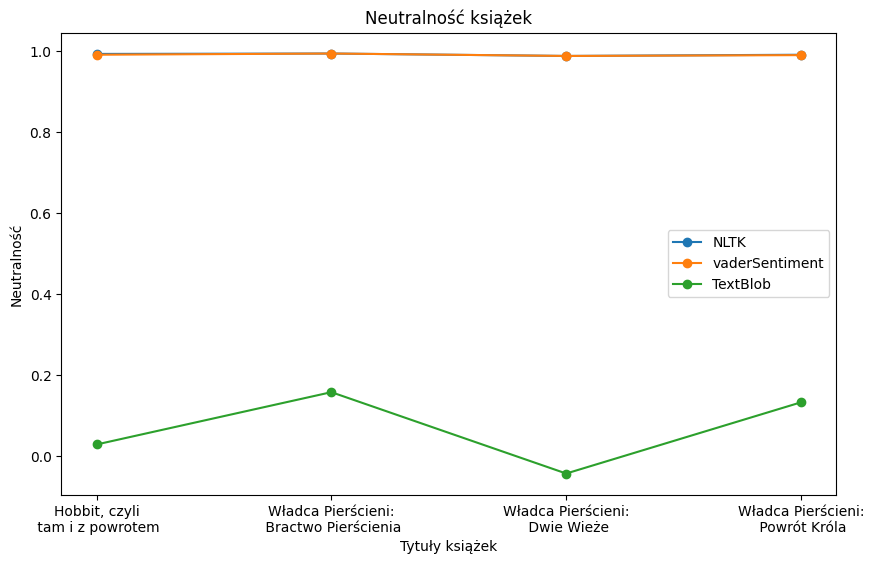

In [38]:
books = ['Hobbit, czyli\n tam i z powrotem', 'Władca Pierścieni:\n Bractwo Pierścienia', 'Władca Pierścieni:\n Dwie Wieże', 'Władca Pierścieni:\n Powrót Króla']

#Wyniki neutralności
nltk_neutral = [book1_nltk_sentiment['neu'], book2_nltk_sentiment['neu'], book3_nltk_sentiment['neu'], book4_nltk_sentiment['neu']]
vader_neutral = [book1_vader_sentiment['neu'], book2_vader_sentiment['neu'], book3_vader_sentiment['neu'], book4_vader_sentiment['neu']]
textblob_neutral = [book1_textblob_sentiment, book2_textblob_sentiment, book3_textblob_sentiment, book4_textblob_sentiment]

#Utworzenie wykresu
plt.figure(figsize=(10, 6))

#Wykres dla NLTK
plt.plot(books, nltk_neutral, label='NLTK', marker='o')

#Wykres dla VaderSentiment
plt.plot(books, vader_neutral, label='vaderSentiment', marker='o')

#Wykres dla TextBlob
plt.plot(books, textblob_neutral, label='TextBlob', marker='o')

plt.title('Neutralność książek')
plt.xlabel('Tytuły książek')
plt.ylabel('Neutralność')
plt.legend()

plt.show()

Analiza wskaźników polaryzacji nastroju z wykorzystaniem bibliotek: `NLTK`, `TextBlob` i `vaderSentiment`, pozwala nam ocenić neutralność treści zawartych w poszczególnych książkach.

W przypadku biblioteki `NLTK`, wartości `'neu'` wskazują na neutralność tekstu. Wyniki pokazują, że wszystkie cztery książki mają wysokie wartości neutralności, co oznacza, że większość treści tych książek jest neutralna.

Przy użyciu biblioteki `TextBlob`, wskaźniki polaryzacji nastroju są wyrażone jako liczby z zakresu od -1 do 1, gdzie wartość bliska 0 wskazuje na neutralność. Analiza wskazuje, że większość książek osiąga wartości bliskie zeru, co sugeruje neutralność ich treści. Jednak książka "Władca pierścieni. Bractwo Pierścienia. Tom 1" ma wartość polaryzacji nastroju nieco wyższą od pozostałych książek, co może wskazywać na większą zmienność nastroju w tej części sagi.

W przypadku biblioteki `vaderSentiment`, wartość neu również wskazuje na neutralność tekstu. Wszystkie cztery książki mają wysokie wartości neutralności, co podobnie jak w przypadku NLTK sugeruje, że większość treści w tych książkach jest neutralna.

Podsumowując, analiza wskaźników polaryzacji nastroju z użyciem tych 3 bibliotek wskazuje na fakt, iż treści w badanych książkach są neutralne. Wydaje się to być oczywistym wnioskiem, ponieważ powieści fantastyczne charakteryzują się stylem oraz tonem pozbawionym wyrażeń mających na celu coś lub kogoś pochwalić albo obrazić, dlatego trudno tu mowić o pozytywnym bądź negatywnym nacechowaniu. Tego typu książki nasycone są morałami, alegoriami oraz treścią budzącą u czytelnika emocje, nawołującą go do refleksji i własnej interpretacji, jednak same w sobie mają neutralny wydźwięk.